In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
!pip install transformers

In [89]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import gdown
import plotly.express as px
import plotly.graph_objects as go
from tensorflow.keras import backend as K
from sklearn.cluster import KMeans
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import recall_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from transformers import AutoModel, BertTokenizerFast, TFBertForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import pipeline

In [90]:
## https://drive.google.com/file/d/1ipj56-DHvYFDnOf1CiF0oU-wxQMHSZgJ/view?usp=sharing

df_bot_detection = '1ipj56-DHvYFDnOf1CiF0oU-wxQMHSZgJ'
url_bot_detection = f'https://drive.google.com/uc?id={df_bot_detection}'
df_bot_detection = pd.read_csv(url_bot_detection)

In [91]:
df_bot_detection.columns.values

array(['User ID', 'Username', 'Tweet', 'Retweet Count', 'Mention Count',
       'Follower Count', 'Verified', 'Bot Label', 'Location',
       'Created At', 'Hashtags'], dtype=object)

In [92]:
df_bot_detection.shape

(50000, 11)

In [93]:
df_bot_detection['Tweet']

,Tweet
0,Station activity person against natural majori...
1,Authority research natural life material staff...
2,Manage whose quickly especially foot none to g...
3,Just cover eight opportunity strong policy which.
4,Animal sign six data good or.
...,...
49995,Want but put card direction know miss former h...
49996,Provide whole maybe agree church respond most ...
49997,Bring different everyone international capital...
49998,Than about single generation itself seek sell ...


In [94]:
df_bot_detection['Bot Label'].value_counts(normalize = True)

,proportion
Bot Label,
1,0.50036
0,0.49964


## Import BERT Model and Tokenizer

In [95]:
bert = AutoModel.from_pretrained('bert-base-cased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [96]:
text = ["Sampling text, trying to make it to São Paulo Futebol Clube"]

send_encoded_input = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [97]:
print(send_encoded_input)

{'input_ids': [[101, 2687, 11624, 3087, 117, 1774, 1106, 1294, 1122, 1106, 7447, 8764, 14763, 1566, 15792, 28070, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


## Splitting train dataset into train, validation and test

In [98]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df_bot_detection['Tweet'], df_bot_detection['Bot Label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df_bot_detection['Bot Label'])


val_text, test_text, val_test_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                        random_state=2018,
                                                                        test_size=0.5,
                                                                        stratify=temp_labels)

### Encoding Text Sequences

<Axes: >

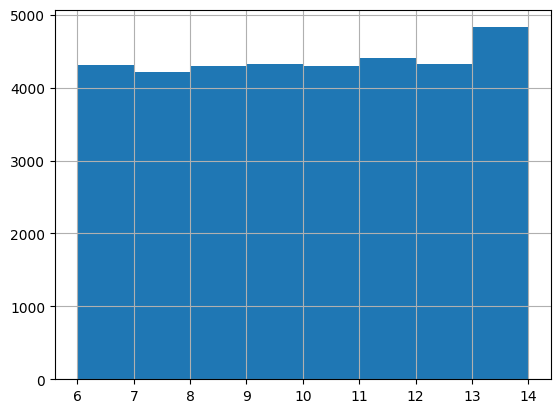

In [99]:
sequence_len = [len(i.split()) for i in train_text]

pd.Series(sequence_len).hist(bins=8)

In [100]:
max_seq_len = 20

In [101]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [102]:
import torch
import torch.nn as nn

In [103]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_test_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### Train

Confirmação do que eu estou fazendo

In [104]:
print(train_seq)
print(train_mask)
print(f'Labels definidos para treino: {train_y}')

tensor([[  101,  2279,  3719,  ...,     0,     0,     0],
        [  101,  5096,  7641,  ...,     0,     0,     0],
        [  101,  7817,  3068,  ...,     0,     0,     0],
        ...,
        [  101,  4435,  2704,  ...,     0,     0,     0],
        [  101, 23543,  1858,  ...,     0,     0,     0],
        [  101,   138,  6005,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Labels definidos para treino: tensor([1, 0, 0,  ..., 0, 1, 1])


In [105]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [106]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokens_train), train_labels)).shuffle(1000).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(tokens_test), test_labels)).batch(64)

In [111]:
from torch.optim import Adam
from transformers import AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = ['accuracy']

bert_model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [ ]:
bert_model.fit(train_dataset, epochs=2)

# Avaliar o modelo com os dados de teste
y_pred_prob = bert_model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob.logits, axis=1)

Epoch 1/2
170/547 [========>.....................] - ETA: 1:39:03 - loss: 0.7021 - accuracy: 0.4957

In [ ]:
# sample_size = 5000
# X_train_sample = X_train.sample(n=sample_size, random_state=42)
# y_train_sample = y_train.loc[X_train_sample.index]

# X_test_sample = X_test.sample(n=sample_size, random_state=42)
# y_test_sample = y_test.loc[X_test_sample.index]

In [ ]:
# Calcular e imprimir a precisão e acurácia
accuracy = accuracy_score(y_test_sample, y_pred)
precision = precision_score(y_test_sample, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')